# Message Concealment Scheme - Text

## Libraries and initial setup

In [1]:
!pip3 install gmpy2
!pip3 install tensorflow

%matplotlib inline

import ctypes
import gmpy2
from gmpy2 import mpz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

In [20]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-gpu
# !pip install keras==2.3.1



In [3]:
from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, RMSprop
# from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model

Using TensorFlow backend.


In [22]:
# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

In [23]:
def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

## Model Building

### Alice

In [29]:
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('relu')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(areshape)
aconv1a = Activation('sigmoid')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('sigmoid')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('sigmoid')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('tanh')(aconv4)

aoutput = Flatten()(aconv4a)

alice = Model([ainput0, ainput1], aoutput, name='alice')
# alice.summary()


### Bob

In [30]:
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('relu')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(breshape)
bconv1a = Activation('sigmoid')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1a)
bconv2a = Activation('sigmoid')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('sigmoid')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('tanh')(bconv4)

boutput = Flatten()(bconv4a)

bob = Model([binput0, binput1], boutput, name='bob')

# bob.summary()

### Eve

In [31]:
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('relu')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('relu')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape)
econv1a = Activation('sigmoid')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('sigmoid')(econv2)
econv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('sigmoid')(econv3)
econv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a)
econv4a = Activation('tanh')(econv4)

eoutput = Flatten()(econv4a)# Eve's attempt at code guessing

eve = Model(einput, eoutput, name='eve')

# eve.summary()

In [32]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [28]:
# !pip install pydot

# from keras.utils import plot_model

# plot_model(model=alice)

## Loss Functions and Optimizers

In [33]:
m_train = 2**(m_bits) #+ k_bits)
# alice = load_model('../models/alice.h5')
# bob = load_model('../models/bob.h5')
# eve = load_model('../models/eve.h5')

In [34]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/opt/anaconda3/envs/tensor_env/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/opt/anaconda3/envs/tensor_env/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


## Training and Dump

In [38]:
abelosses = []
boblosses = []
evelosses = []

alice = load_model('../models/alice.h5')
bob = load_model('../models/bob.h5')
eve = load_model('../models/eve.h5')

In [37]:
n_epochs = 120
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = [] 
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 120 epochs with 128 batches of size 512
Epoch   0:  99% | abe: 1.020 | eve: 0.165 | bob: 0.043
Epoch   1:  99% | abe: 1.014 | eve: 0.152 | bob: 0.043
Epoch   2:  99% | abe: 1.011 | eve: 0.149 | bob: 0.043
Epoch   3:  99% | abe: 1.009 | eve: 0.148 | bob: 0.043
Epoch   4:  99% | abe: 1.007 | eve: 0.141 | bob: 0.043
Epoch   5:  99% | abe: 1.006 | eve: 0.150 | bob: 0.043
Epoch   6:  99% | abe: 1.001 | eve: 0.171 | bob: 0.043
Epoch   7:  99% | abe: 0.997 | eve: 0.200 | bob: 0.042
Epoch   8:  99% | abe: 0.989 | eve: 0.228 | bob: 0.043
Epoch   9:  99% | abe: 0.983 | eve: 0.270 | bob: 0.043
Epoch  10:  99% | abe: 0.975 | eve: 0.298 | bob: 0.042
Epoch  11:  99% | abe: 0.964 | eve: 0.296 | bob: 0.042
Epoch  12:  99% | abe: 0.962 | eve: 0.324 | bob: 0.042
Epoch  13:  99% | abe: 0.960 | eve: 0.352 | bob: 0.043
Epoch  14:  99% | abe: 0.960 | eve: 0.374 | bob: 0.043
Epoch  15:  99% | abe: 0.958 | eve: 0.387 | bob: 0.043
Epoch  16:  99% | abe: 0.950 | eve: 0.375 | bob: 0.043
Epoch  17:  

KeyboardInterrupt: 

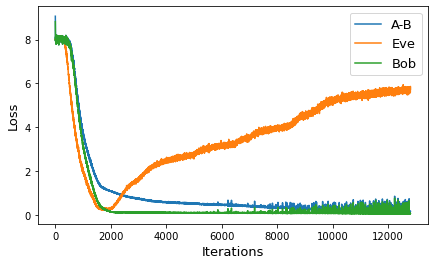

In [44]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

### Saving

In [34]:
# import joblib

# joblib.dump(alice, '/content/drive/MyDrive/FYP-Neural Cryptography/alice.sav')
# joblib.dump(bob, '/content/drive/MyDrive/FYP-Neural Cryptography/bob.sav')
# joblib.dump(eve, '/content/drive/MyDrive/FYP-Neural Cryptography/eve.sav')

In [45]:
# alice.save('alice.h5',overwrite=True)
# bob.save('bob.h5',overwrite=True)
# eve.save('eve.h5',overwrite=True)

## Evaluate

In [2]:
alice1 = load_model('../models/alice.h5')
bob1 = load_model('../models/bob.h5')
eve1 = load_model('../models/eve.h5')
n_examples = 5000000
m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice1.predict([m_batch, k_batch])
m_dec = (bob1.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve1.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

NameError: name 'load_model' is not defined

In [37]:
!python -V

Python 3.7.11


In [11]:
# Input format

# !pip3 install joblib

# load_model works with Python 3.6.13 :: Anaconda, Inc.

import joblib

alice1 = load_model('../models/alice.h5')
bob1 = load_model('../models/bob.h5')
eve1 = load_model('../models/eve.h5')

message = np.array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1],
                    [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]])
key = np.array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1],
                [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])

start_time = datetime.now()
cipher = alice1.predict([message, key])
end_time = datetime.now()
alice_encrypt_time = end_time - start_time

start_time = datetime.now()
decipher = (bob1.predict([cipher, key]) > 0.5).astype(int)
end_time = datetime.now()
bob_decrypt_time = end_time - start_time

adversary = (eve1.predict(cipher) > 0.5).astype(int)

decipher[1]

# Input must be numpy array

NameError: name 'datetime' is not defined

In [ ]:
# !pip install h5py==2.10.0

In [ ]:
(bob.predict([m_enc, k_batch]) > 0.5).astype(int)

In [ ]:
(eve.predict(m_enc) > 0.5 ).astype(int)

 Make Epochs 50 for better visualization

## Performance Benchmarking

In [3]:
#Install the Cryptography module
%pip install cryptography

Note: you may need to restart the kernel to use updated packages.


In [10]:
from datetime import datetime
from cryptography.fernet import Fernet
from helper import *

alice1 = load_model('../models/alice.h5')
bob1 = load_model('../models/bob.h5')
eve1 = load_model('../models/eve.h5')


key = Fernet.generate_key()
cipher_suite = Fernet(key)
#Preprocess the array from input block above
message = 'hello world'

bitMessageAndKey = processRawMessage(message)
bitMessage = bitMessageAndKey[0]
key = bitMessageAndKey[1]

b1 = encstr(message,11)[0]


v2 = []
for i in range(0, len(b1)):
    v2.append(int(b1[i]))


print('Cryptography.fernet AES Encrypt/Decrypt sessions')
print('------------------------------------------------')

start_time = datetime.now()
cipher_text = cipher_suite.encrypt(bytes(v2))
end_time = datetime.now()
fernet_encrypt_time = end_time - start_time
print('cipher text = ', cipher_text)

start_time = datetime.now()
plain_text = cipher_suite.decrypt(cipher_text)
end_time = datetime.now()
fernet_decrypt_time = end_time - start_time
print('plain_text =  ', plain_text)

start_time = datetime.now()
cipher_text = alice1.predict([bitMessage,key])
end_time = datetime.now()
alice_encrypt_time = end_time - start_time
print('cipher text = ', cipher_text[0])

start_time = datetime.now()
plain_text = bob1.predict([cipher_text, key])
end_time = datetime.now()
bob_decrypt_time = end_time - start_time
print('plain_text =  ', plain_text[0])

print('*********Performance of NCA versus Cryptography.Fernet********************')
print('Time taken for Alice to Encrypt the Plain Text (seconds): ', alice_encrypt_time)
print('Time taken for Bob to Decrypt the Cipher Text (seconds): ', bob_decrypt_time)

print('Time taken for Fernet to Encrypt the Plain Text (seconds): ', fernet_encrypt_time)
print('Time taken for Fernet to Decrypt the Cipher Text (seconds): ', fernet_decrypt_time)

Cryptography.fernet AES Encrypt/Decrypt sessions
------------------------------------------------
cipher text =  b'gAAAAABh_9q6i6WcvuY8czV0cPWgHaBzmXzDMcQieh5nIW4yk6stYcl7QPxoVc8zqCHuBA6F_a0G-Dm0ffYRO44Ev14FPXEYVMasWwQSavd31kTfj-EVPzcw7ihIOrq7m6vOfhQuL_exuik5Bu_Adx0aCffLDOjcltAT_q3rqTKj7JGNXblSHzB1owTTQH0_s5wD0CuGOmHIRPC8cN-M66gb0OGBGJK3jDt1MG72CyVMIa_ZRmfsvyE9-jCUWS5ESlEbmwecMKSuATEwgWv_Ln6VcqLdcD81KNcDdujt6xpQZlyU5agV88vzUhMx9UqnXLNzMcepBTAU'
plain_text =   b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x00\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x01\x00\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x00\x01\x01\x01\x01\x00\x00\x00\x00\x00\x

# Image Encryption using ML

## Helper Functions

In [11]:
import numpy as np
import math

MAX_UINT8 = 255
MAX_UINT16 = 65535
MAX_UINT32 = 4294967295

def _logisticmap( x0, a=4-1E-12, init_itr=100 ):
	x = x0
	for i in range(init_itr):
		x = a*x*(1-x)
	while( True ):
		x = a*x*(1-x)
		yield x

class logisticmap:
	def __init__( self, x0, a=4-1E-12, init_itr=100 ):
		self.generator = _logisticmap( x0, a, init_itr )
	def get( self ):
		return self.generator.__next__()

def _enc_process( src, ord ):
	dst = np.copy(src)
	dst[ ord ] = src
	return dst
	
def _dec_process( src, ord ):
	return src[ord]

def paddingBlockSize( X, blockSize ):
	s = X.shape
	
	t = s[0] / blockSize[0]
	d = t - math.floor(t)
	if( d > 0 ):
		paddingSize = blockSize[0] * ( math.floor(t) + 1 ) - s[1]
		padding = X[-1:,:,:]
		padding = np.tile( padding, (paddingSize, 1, 1 ) )
		X = np.concatenate( (X, padding), axis = 0 )

	t = s[1] / blockSize[1]
	d = t - math.floor(t)
	if( d > 0 ):
		paddingSize = blockSize[1] * ( math.floor(t) + 1 ) - s[2]
		padding = X[:,-1:,:]
		padding = np.tile( padding, (1, paddingSize, 1 ) )
		X = np.concatenate( (X, padding), axis = 1 )
	
	return X	

def split_uint8(X):
	assert(X.dtype == np.uint8)
	X1 = X >> 4
	X0 = X & 0x0F
	return np.concatenate( (X1, X0), axis=2 )

def join_uint8(X):
	assert(X.dtype == np.uint8)
	assert(X.shape[2] % 2 == 0)
	s = X.shape[2]//2
	X1 = X[:,:,:s]
	X0 = X[:,:,s:]
	return ( X1 << 4 ) + X0

## RegConst

In [12]:
from keras import backend as K
from keras.regularizers import Regularizer
from keras.constraints import Constraint

class ConstInterp(Constraint):
	def __call__(self, w):
		w *= K.cast(K.greater_equal(w, 0.), K.floatx())
		w /= K.epsilon() + K.sum(w, axis=[0,1,2], keepdims=True)
		return w

class ConstNorm(Constraint):
	def __init__(self, axis=2, nb_pixels=1):
		self.axis = axis
		self.nb_pixels=nb_pixels

	def __call__(self, w):
		w /= K.epsilon() + K.sqrt(K.sum(K.square(w), axis=self.axis, keepdims=True))
		w /= self.nb_pixels
		return w

	def get_config(self):
		return {'axis': self.axis, 'nb_pixels':self.nb_pixels}

class L1L2mean(Regularizer):
	def __init__(self, l1=0., l2=0.):
		self.l1 = l1
		self.l2 = l2

	def __call__(self, x):
		regularization = 0.
		if self.l1:
			regularization += self.l1 * K.mean(K.abs(x))
		if self.l2:
			regularization += self.l2 * K.mean(K.square(x))
		return regularization

	def get_config(self):
		return {\
		'l1': float(self.l1),\
		'l2': float(self.l2),\
		}

## Image Shuffling

In [13]:
import numpy as np

def _enc_process( src, ord ):
	dst = np.copy(src)
	dst[ ord ] = src
	return dst
	
def _dec_process( src, ord ):
	return src[ord]
	
class Rand:
	def __init__( self, key ):
		self.key = key
		self.ord = None
		self.roiSize = None
		self.rand_init()
	
	def rand_init( self ):
		self.rand_generator = logisticmap( float(self.key)/MAX_UINT32 * (1.0-2.0E-12 ) + 1.0E-12 )
	
	def rand( self ):
		return self.rand_generator.get()
	
	def setOrd( self, roiSize ):
		if( self.roiSize != roiSize ):
			self.roiSize = roiSize
			self.rand_init()
			self.ord = self.calcOrd()
	
	def process( self, input, func ):
		roiSize = self.calcRoiSize( input )
		self.setOrd( roiSize )
		
		src = np.copy( input[:roiSize[0], :roiSize[1], :] )
		
		src = np.reshape( src, (roiSize[0]*roiSize[1]*roiSize[2]) )
		dst = func( src, self.ord )
		
		output = np.copy( input )
		output[ :roiSize[0], :roiSize[1], : ] = np.reshape( dst, roiSize )
		
		return output
	
	def enc( self, input ):
		return self.process( input, _enc_process )

	def dec( self, input ):
		return self.process( input, _dec_process )
		
		
	######
	def calcRoiSize( self, input ):
		return input.shape

	def calcOrd( self ):
		return np.argsort( np.array( [ self.rand() for i in range(self.roiSize[0] * self.roiSize[1] * self.roiSize[2]) ] ) )


class RandBlock(Rand):
	def __init__( self, key, blockSize ):
		super(RandBlock, self).__init__(key)
		self.blockSize = blockSize

	######
	def calcRoiSize( self, input ):
		inputshape = input.shape
		
		s0 = (inputshape[0] // self.blockSize[0]) * self.blockSize[0]
		s1 = (inputshape[1] // self.blockSize[1]) * self.blockSize[1]
		
		return (s0,s1,inputshape[2])

	def calcOrd( self ):
		imShuffle = Rand( self.key )
		
		ord = np.array( list(range(self.roiSize[0] * self.roiSize[1] * self.roiSize[2])) )
		ord = np.reshape( ord, self.roiSize )
		
		nb_blocks0 = self.roiSize[0] // self.blockSize[0]
		nb_blocks1 = self.roiSize[1] // self.blockSize[1]
		
		for row in range(nb_blocks0):
			for col in range(nb_blocks1):
				ord[row*self.blockSize[0]:(row+1)*self.blockSize[0], col*self.blockSize[1]:(col+1)*self.blockSize[1], :] = \
				imShuffle.enc( ord[row*self.blockSize[0]:(row+1)*self.blockSize[0], col*self.blockSize[1]:(col+1)*self.blockSize[1], :] )
		
		return np.reshape( ord, (self.roiSize[0] * self.roiSize[1] * self.roiSize[2]) )


def genCatMapInd( size, rowroll, colroll, p, q, r ):
	rind = np.reshape( np.array(list(range(size))), (size, 1, 1) )
	rind = np.tile( rind, (1, size, 1) )
	rind = np.roll( rind, rowroll, axis=0 )
	
	cind = np.reshape( np.array(list(range(size))), (1, size, 1) )
	cind = np.tile( cind, (size, 1, 1) )
	cind = np.roll( cind, colroll, axis=1 )
	
	ind = np.concatenate( (rind, cind), axis=2 )
	
	'''
	a00 = 1.
	a01 = p
	a10 = q
	a11 = 1. + p*q
	'''
	
	for i in range(r):
		ind0 = np.copy(ind)
		ind[:,:,0] = np.mod( ind0[:,:,0] + p * ind0[:,:,1], size )
		ind[:,:,1] = np.mod( q * ind0[:,:,0] + (1.+p*q) * ind0[:,:,1], size )
	
	return ind

def genArnoldCatMapInd( size, r ):
	return genCatMapInd( size, 0, 0, 1, 1, r )


class CatMap(Rand):
	def __init__( self, key, Arnold = False, channel_shuffle = True ):
		super(CatMap, self).__init__(key)
		self.Arnold = Arnold
		self.channel_shuffle = channel_shuffle

	######
	def calcRoiSize( self, input ):
		inputshape = input.shape
		s = min( inputshape[0], inputshape[1] )
		return (s,s,inputshape[2])

	def calcOrd( self ):
		ord = np.array( list(range(self.roiSize[0] * self.roiSize[1] * self.roiSize[2])) )
		ord = np.reshape( ord, self.roiSize )
		ord0 = np.copy( ord )

		if( self.channel_shuffle ):
			for row in range(self.roiSize[0]):
				for col in range(self.roiSize[1]):
					roll = int(self.rand()*self.roiSize[2])
					ord0[row,col,:] = np.roll( ord0[row,col,:], roll, axis=0 )
		
		s = self.roiSize[0]
		for cha in range(self.roiSize[2]):
			if( self.Arnold ):
				rowroll = int(self.rand() * s)
				colroll = int(self.rand() * s)
				p = int(self.rand() * s)
				q = int(self.rand() * s)
			else:
				rowroll = 0
				colroll = 0
				p = 1
				q = 1
			
			r = 2 + int(self.rand()*8)
			ind = genCatMapInd( s, rowroll, colroll, p, q, r )
			for row in range(self.roiSize[0]):
				for col in range(self.roiSize[1]):
					row1 = ind[row,col,0]
					col1 = ind[row,col,1]
					ord[row1,col1,cha] = ord0[row,col,cha]
		
		return np.reshape( ord, (self.roiSize[0] * self.roiSize[1] * self.roiSize[2]) )


class CatMapComb(CatMap):
	def __init__( self, key, Arnold = False, channel_shuffle = True ):
		super(CatMapComb, self).__init__(key, Arnold, channel_shuffle )
	
	######
	def calcRoiSize( self, input ):
		inputshape = input.shape
		s = min( inputshape[0], inputshape[1] )
		return (s,s,inputshape[2])
	
	def calcOrd( self ):
		ord = np.array( list(range(self.roiSize[0] * self.roiSize[1] * self.roiSize[2])) )
		ord = np.reshape( ord, self.roiSize )
		ord0 = np.copy( ord )
		
		s = self.roiSize[0] // 2
		
		imShuffle = CatMap( self.rand()*MAX_UINT32, self.Arnold, self.channel_shuffle )
		ord[:s, :s, :] = imShuffle.enc( ord[:s, :s, :] )
		
		imShuffle = CatMap( self.rand()*MAX_UINT32, self.Arnold, self.channel_shuffle )
		ord[:s, -s:, :] = imShuffle.enc( ord[:s, -s:, :] )

		imShuffle = CatMap( self.rand()*MAX_UINT32, self.Arnold, self.channel_shuffle )
		ord[-s:, :s, :] = imShuffle.enc( ord[-s:, :s, :] )
		
		imShuffle = CatMap( self.rand()*MAX_UINT32, self.Arnold, self.channel_shuffle )
		ord[-s:, -s:, :] = imShuffle.enc( ord[-s:, -s:, :] )

		ind0 = range(0, self.roiSize[0], 2 )
		ind1 = range(1, self.roiSize[0], 2 )
		
		ord0 = np.copy( ord )
		ord[ind0, :, :] = ord0[:len(ind0), :, :]
		ord[ind1, :, :] = ord0[len(ind0):, :, :]

		ord0 = np.copy( ord )
		ord[:, ind0, :] = ord0[:, :len(ind0), :]
		ord[:, ind1, :] = ord0[:, len(ind0):, :]

		imShuffle = CatMap( self.rand()*MAX_UINT32, self.Arnold, self.channel_shuffle )
		ord = imShuffle.enc( ord )


		return np.reshape( ord, (self.roiSize[0] * self.roiSize[1] * self.roiSize[2]) )

## Model Building

In [ ]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-

from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input, Lambda
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Add, Concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.datasets import cifar10, cifar100
from keras.utils import np_utils
import keras.backend as K

import numpy as np
import random

def resnet(input_shape, nb_classes=10):
	p1 = PaddingReplicate2D((1,1))
	inp = Input(shape=input_shape)
	x = inp

	# block0 ####################################################
	x = BatchNormalization() (x)
	x = Conv2D( 4*4*3, (4,4), padding='valid', strides=(4,4), kernel_initializer='he_normal' ) (x)
	x = Activation('relu') (x)
	# 8x8x48
	
	x = BatchNormalization() (x)
	x = Conv2D( 4*4*3, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
	x = Activation('relu') (x)
	# 8x8x48

	x = BatchNormalization() (x)
	x = Conv2D( 4*4*32, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
	x = PixelShuffle( x, 4 )
	# 32x32x32


	# block1 ####################################################
	f = 32
	fs = 16
	for i in range(2):
		f0 = f
		f = f+fs
		r = x
		
		r = BatchNormalization() (r)
		r = Activation('relu') (r)
		r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))

		r = BatchNormalization() (r)
		r = Activation('relu') (r)
		r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))
		
		r = Dropout(0.25) (r)

		r0 = Lambda(lambda x: x[:,:,:,:f0], lambda s: (s[0], s[1], s[2], f0) ) (r)
		r1 = Lambda(lambda x: x[:,:,:,f0:], lambda s: (s[0], s[1], s[2], fs) ) (r)
		
		x = Add() ( [x,r0] )
		x = Concatenate(axis=-1) ([x,r1])
		
		f0 = f
	# 32x32x64

	x = MaxPooling2D(pool_size=(2, 2)) (x)
	# 16x16x64


	# block2 ####################################################
	f = 64
	fs = 32
	for i in range(2):
		f0 = f
		f = f+fs
		r = x
		
		r = BatchNormalization() (r)
		r = Activation('relu') (r)
		r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))

		r = BatchNormalization() (r)
		r = Activation('relu') (r)
		r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))
		
		r = Dropout(0.25) (r)

		r0 = Lambda(lambda x: x[:,:,:,:f0], lambda s: (s[0], s[1], s[2], f0) ) (r)
		r1 = Lambda(lambda x: x[:,:,:,f0:], lambda s: (s[0], s[1], s[2], fs) ) (r)

		x = Add() ( [x,r0] )
		x = Concatenate(axis=-1) ([x,r1])
		
		f0 = f
	# 16x16x128
	
	x = MaxPooling2D(pool_size=(2, 2)) (x)
	# 8x8x128

	# block3 ####################################################
	f = 128
	fs = 64
	for i in range(2):
		f0 = f
		f = f+fs
		r = x
		
		r = BatchNormalization() (r)
		r = Activation('relu') (r)
		r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))

		r = BatchNormalization() (r)
		r = Activation('relu') (r)
		r = Conv2D( f, (3,3), padding='valid', kernel_initializer='he_normal' ) (p1(r))
		
		r = Dropout(0.25) (r)

		r0 = Lambda(lambda x: x[:,:,:,:f0], lambda s: (s[0], s[1], s[2], f0) ) (r)
		r1 = Lambda(lambda x: x[:,:,:,f0:], lambda s: (s[0], s[1], s[2], fs) ) (r)

		x = Add() ( [x,r0] )
		x = Concatenate(axis=-1) ([x,r1])
		
		f0 = f
	# 8x8x256
	
	x = MaxPooling2D(pool_size=(2, 2)) (x)
	# 4x4x256

	# block4 ####################################################
	x = Dropout(0.5) (x)
	x = Conv2D( 512, (1,1), padding='valid', kernel_initializer='he_normal', activation='relu' ) (x)

	x = Dropout(0.5) (x)
	x = Conv2D( nb_classes, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
	x = GlobalAveragePooling2D() (x)
	x = Activation('softmax') (x)

	return Model(inputs=inp, outputs=x)

## Block Scrambling

In [18]:
import numpy as np
import math
try:
	import cPickle as pickle
except:
	import pickle

class BlockScramble:
	def __init__( self, blockSize_filename ):
		if( isinstance( blockSize_filename, str ) ):
			self.load( blockSize_filename )
		else:
			self.blockSize = blockSize_filename
			key = self.genKey()
			self.setKey( key )

	def setKey( self, key ):
		self.key = key
		self.rev = ( key > key.size/2 )
		self.invKey = np.argsort(key)
	
	def load( self, filename ):
		fin = open(filename, 'rb')
		self.blockSize, self.key = pickle.load( fin )
		fin.close()
		
		self.setKey( self.key )
	
	def save( self, filename ): # pkl
		fout = open(filename, 'wb')
		pickle.dump( [self.blockSize, self.key], fout )
		fout.close()		
	
	def genKey( self ):
		key = self.blockSize[0] * self.blockSize[1]*self.blockSize[2]
		key = np.arange(key*2, dtype=np.uint32)
		np.random.shuffle(key)
		return key
		
	def padding( self, X ): # X is [datanum, width, height, channel]
		s = X.shape
		
		t = s[1] / self.blockSize[0]
		d = t - math.floor(t)
		if( d > 0 ):
			paddingSize = self.blockSize[0] * ( math.floor(t) + 1 ) - s[1]
			padding = X[:,-1:,:,:]
			padding = np.tile( padding, (1, paddingSize, 1, 1 ) )
			X = np.concatenate( (X, padding), axis = 1 )

		t = s[2] / self.blockSize[1]
		d = t - math.floor(t)
		if( d > 0 ):
			paddingSize = self.blockSize[1] * ( math.floor(t) + 1 ) - s[2]
			padding = X[:,:,-1:,:]
			padding = np.tile( padding, (1, 1, paddingSize, 1 ) )
			X = np.concatenate( (X, padding), axis = 2 )
		
		return X
	
	def Scramble(self, X):
		XX = (X * 255).astype(np.uint8)
		XX = self.doScramble(XX, self.key, self.rev)
		return XX.astype('float32')/255.0
		
	def Decramble(self, X):
		XX = (X * 255).astype(np.uint8)
		XX = self.doScramble(XX, self.invKey, self.rev)
		return XX.astype('float32')/255.0
	
	def doScramble(self, X, ord, rev): # X should be uint8
		s = X.shape
		assert( X.dtype == np.uint8 )
		assert( s[1] % self.blockSize[0] == 0 )
		assert( s[2] % self.blockSize[1] == 0 )
		assert( s[3] == self.blockSize[2] )
		numBlock = np.int32( [ s[1] / self.blockSize[0], s[2] / self.blockSize[1] ] );
		numCh = self.blockSize[2];
		
		X = np.reshape( X, ( s[0], numBlock[0], self.blockSize[0], numBlock[1], self.blockSize[1],  numCh ) )
		X = np.transpose( X, (0, 1, 3, 2, 4, 5) )
		X = np.reshape( X, ( s[0], numBlock[0], numBlock[1], self.blockSize[0] * self.blockSize[1] * numCh ) )
		d = self.blockSize[0] * self.blockSize[1] * numCh;
		
		X0 = X & 0xF
		X1 = X >> 4
		X = np.concatenate( (X0,X1), axis=3 )
		
		X[:,:,:,rev] = ( 15 - X[:,:,:,rev].astype(np.int32) ).astype(np.uint8)
		X = X[:,:,:,ord]
		X[:,:,:,rev] = ( 15 - X[:,:,:,rev].astype(np.int32) ).astype(np.uint8)

		X0 = X[:,:,:,:d]
		X1 = X[:,:,:,d:]
		X = ( X1 << 4 ) + X0
		
		X = np.reshape( X, ( s[0], numBlock[0], numBlock[1], self.blockSize[0], self.blockSize[1], numCh ) )
		X = np.transpose( X, ( 0, 1, 3, 2, 4, 5) )
		X = np.reshape( X, ( s[0], numBlock[0] * self.blockSize[0], numBlock[1] * self.blockSize[1], numCh ) );
		
		return X

if( __name__ == '__main__' ):
	from PIL import Image
	import os

	im = Image.open('test_bs1.png')
	data = np.asarray(im, dtype=np.uint8)
	data = np.reshape( data, (1,)+data.shape )
	print(data.shape)
	
	key_file = 'key.pkl'
	
	if( os.path.exists(key_file) ):
		bs = BlockScramble( key_file )
	else:
		bs = BlockScramble( [4,4,3] )
		bs.save(key_file)
	
	data = bs.padding( data )
	print(data.shape)
	
	im = Image.fromarray( data[0,:,:,:] )
	im.save('test_bs1.png')
	
	data = bs.Scramble( data )
	im = Image.fromarray( data[0,:,:,:] )
	im.save('test_bs2.png')

	data = bs.Decramble( data )
	im = Image.fromarray( data[0,:,:,:] )
	im.save('test_bs3.png')

FileNotFoundError: [Errno 2] No such file or directory: 'test_bs1.png'

## Run Demo

In [ ]:
from keras.datasets import cifar10, cifar100
from keras.utils import np_utils
from keras import backend as K
from keras.metrics import categorical_accuracy

K.set_image_data_format('channels_last')

import numpy as np
from padding import PaddingReplicate2D
from pixelshuffle import PixelShuffle_calc, PixelShuffle_shape
import build_model
import imageshuffle
from BlockScramble import BlockScramble



def load_cifar10():
	(X_train, y_train), (X_test, y_test) = cifar10.load_data()
	Y_train = np_utils.to_categorical(y_train, 10)
	Y_train = np.single( Y_train )
	Y_test  = np_utils.to_categorical(y_test, 10)
	Y_test = np.single( Y_test )
	
	X_train = X_train.astype('float32')/255.0
	X_test = X_test.astype('float32')/255.0

	return (X_train, Y_train), (X_test, Y_test)

def load_cifar100():
	(X_train, y_train), (X_test, y_test) = cifar100.load_data()
	Y_train = np_utils.to_categorical(y_train, 100)
	Y_train = np.single( Y_train )
	Y_test  = np_utils.to_categorical(y_test, 100)
	Y_test = np.single( Y_test )
	
	X_train = X_train.astype('float32')/255.0
	X_test = X_test.astype('float32')/255.0

	return (X_train, Y_train), (X_test, Y_test)

modelnames = ['direct', 'catmap', 'block', 'propose']
for nb_classes in [10,100]:
	
	if( nb_classes == 10 ):
		(X_train, Y_train), (X_test0, Y_test) = load_cifar10()
	elif( nb_classes == 100 ):
		(X_train, Y_train), (X_test0, Y_test) = load_cifar100()
	
	for modelname in modelnames:
		name = modelname + '{n:03d}'.format(n=nb_classes)
		model = build_model.resnet(input_shape=[32,32,3], nb_classes=nb_classes)
		model.load_weights( 'weights/' + name + '.hdf5' )
		
		X_test = np.copy(X_test0)
		if( modelname == 'catmap' ):
			imShuffle = imageshuffle.CatMapComb(1234)
			for i in range(X_test.shape[0]):
				X_test[i,:,:,:] = imShuffle.enc( X_test[i,:,:,:] )
		
		elif( modelname == 'block' ):
			imShuffle = imageshuffle.RandBlock(1234, (4,4) )
			for i in range(X_test.shape[0]):
				X_test[i,:,:,:] = imShuffle.enc( X_test[i,:,:,:] )

		elif( modelname == 'propose' ):
			bs = BlockScramble( 'key.pkl' )
			X_test = bs.Scramble( X_test )
		
		Y_pred = model.predict( X_test )
		acc = categorical_accuracy( Y_test, Y_pred )
		acc = K.get_value(acc)
		print( '{name:s}: {acc:5.3f}'.format(name=name, acc=np.mean(acc)) )

## Padding

In [14]:
import keras.backend as K
from keras.engine.topology import Layer
from keras.engine import InputSpec
from keras.utils import conv_utils

class PaddingReplicate2D(Layer):
	def __init__(self, size=(1, 1), data_format=None, **kwargs):
		super(PaddingReplicate2D, self).__init__(**kwargs)
		self.data_format = conv_utils.normalize_data_format(data_format)
		self.size = conv_utils.normalize_tuple(size, 2, 'size')
		self.input_spec = InputSpec(ndim=4)
	
	def compute_output_shape(self, input_shape):
		if( self.data_format == 'channels_first' ):
			height = self.size[0] * 2 + input_shape[2] if input_shape[2] is not None else None
			width = self.size[1] * 2 + input_shape[3] if input_shape[3] is not None else None
			return (input_shape[0], input_shape[1], height, width)
			
		elif( self.data_format == 'channels_last' ):
			height = self.size[0] * 2 + input_shape[1] if input_shape[1] is not None else None
			width = self.size[1] * 2 + input_shape[2] if input_shape[2] is not None else None
			return (input_shape[0], height, width, input_shape[3])

	def call(self, inputs):
		if( self.data_format == 'channels_first' ):
			t0 = inputs[:,:,:1,:]
			t1 = inputs[:,:,-1:,:]
			if( self.size[0] > 1 ):
				t0 = K.repeat_elements( t0, self.size[0], axis=2 )
				t1 = K.repeat_elements( t1, self.size[0], axis=2 )
			t = K.concatenate( [t0, inputs, t1], axis=2 )
			
			t0 = t[:,:,:,:1]
			t1 = t[:,:,:,-1:]
			if( self.size[1] > 1 ):
				t0 = K.repeat_elements( t0, self.size[1], axis=3 )
				t1 = K.repeat_elements( t1, self.size[1], axis=3 )
			outputs = K.concatenate( [t0, t, t1], axis=3 )
			
		elif( self.data_format == 'channels_last' ):
			t0 = inputs[:,:1,:,:]
			t1 = inputs[:,-1:,:,:]
			if( self.size[0] > 1 ):
				t0 = K.repeat_elements( t0, self.size[0], axis=1 )
				t1 = K.repeat_elements( t1, self.size[0], axis=1 )
			t = K.concatenate( [t0, inputs, t1], axis=1 )
			
			t0 = t[:,:,:1,:]
			t1 = t[:,:,-1:,:]
			if( self.size[1] > 1 ):
				t0 = K.repeat_elements( t0, self.size[1], axis=2 )
				t1 = K.repeat_elements( t1, self.size[1], axis=2 )
			outputs = K.concatenate( [t0, t, t1], axis=2 )
		
		else:
			outputs = None
		
		return outputs


	def get_config(self):
		config = {'size': self.size, 'data_format': self.data_format}
		base_config = super(PaddingReplicate2D, self).get_config()
		return dict(list(base_config.items()) + list(config.items()))

if( __name__ == '__main__' ):
	t = K.ones((4, 3))
	print(K.eval(t))

	t0 = t[:1,:] - 1
	print(K.eval(t0))

	t1 = t[-1:,:] + 1
	t1 = K.repeat_elements( t1, 3, axis=0 )
	print(K.eval(t1))
	
	t = K.concatenate( [t0, t, t1], axis=0 )
	print(K.eval(t))

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[0. 0. 0.]]
[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]
[[0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]


## Pixel Shuffle

In [17]:
from keras import backend as K
from keras.layers import Layer, Lambda, Conv2D
from keras.initializers import RandomUniform


def PixelShuffle_calc(inputs, r):
	input_shape = K.int_shape(inputs)
	batch_size, h, w, c = input_shape
	if batch_size is None:
		batch_size = -1
	rh = r
	rw = r
	oh, ow = h * rh, w * rw
	oc = c // (rh * rw)

	outputs = K.reshape(inputs, (batch_size, h, w, rh, rw, oc))
	outputs = K.permute_dimensions(outputs, (0, 1, 3, 2, 4, 5))
	outputs = K.reshape(outputs, (batch_size, oh, ow, oc))
	return outputs

def PixelShuffle_shape(s, r):
	h = s[1] * r
	w = s[2] * r
	c = s[3] // (r*r)
	return (s[0], h, w, c)

def PixelShuffle( x, ratio ):
	return Lambda( lambda x: PixelShuffle_calc(x, ratio), lambda s: PixelShuffle_shape(s, ratio) ) (x)

def PSUpsampling( x, nb_features, ratio ):
	p1 = PaddingReplicate2D((1,1))
	x = Conv2D( nb_features*ratio*ratio, (3,3), activation='linear', padding='valid', kernel_initializer=RandomUniform(0., 1.0), kernel_constraint=ConstInterp(), use_bias=False ) (p1(x))
	x = PixelShuffle( x, ratio )
	x = Conv2D( nb_features, (3,3), activation='linear', padding='valid', kernel_initializer=RandomUniform(0., 1.0), kernel_constraint=ConstInterp(), use_bias=False ) (p1(x))
	return x

# MODEL 2 - adds dense and tanh codings 

In [4]:
K.floatx()

'float32'

In [6]:
model_name = 'crypto2'

# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 8
k_bits = 8
c_bits = 8
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits + k_bits)

alice_file = './models/crypto/' + model_name + '-alice'
bob_file = './models/crypto/' + model_name + '-bob'
eve_file = './models/crypto/' + model_name + '-eve'

## Network Architecture

In [9]:
K.clear_session()
kersize = 4

### Alice

In [10]:
##### Alice network #####
#
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)

areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('tanh')(aconv4)

aflat = Flatten()(aconv4a)
aoutput = Dense(units=c_bits, activation='tanh')(aflat) #ciphertext

alice = Model([ainput0, ainput1], aoutput, name='alice')
alice.summary()

Model: "alice"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 16)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         concatenate_1[0][0]          

### Bob

In [11]:
##### Bob network #####
#
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('tanh')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(breshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('tanh')(bconv4)

bflat = Flatten()(bconv4a)
boutput = Dense(units=m_bits, activation='sigmoid')(bflat) #decrypted message

bob = Model([binput0, binput1], boutput, name='bob')
#bob.summary()


### Eve

In [12]:
# Eve network
#
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)
edense2 = Dense(units=(m_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)

ereshape = Reshape((m_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=4, kernel_size=kersize, strides=1, padding=pad)(econv3a)
econv4a = Activation('tanh')(econv4)

eflat = Flatten()(econv4a)
eoutput = Dense(units=m_bits, activation='sigmoid')(eflat) #code break attempt

eve = Model(einput, eoutput, name='eve')
#eve.summary()

In [13]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

In [14]:
if False:
    alice.summary()
    bob.summary()
    eve.summary()

### Loss Functions and Optimizers

In [15]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = Adam()#RMSprop(lr=0.0015)
eveoptim = Adam()#RMSprop(lr=0.0015) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/opt/anaconda3/envs/tensor_env/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output bob missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to bob.
  'be expecting any data to be passed to {0}.'.format(name))
/opt/anaconda3/envs/tensor_env/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output eve missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to eve.
  'be expecting any data to be passed to {0}.'.format(name))


### Train, Save and Restore

In [16]:
# Keep track of loss at every iteration for the final graph
abelosses = []
boblosses = []
evelosses = []

In [24]:
n_epochs = 30
batch_size = 256
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = [] #epoch-bound losses for text display during training
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 30 epochs with 256 batches of size 256
Epoch   0:   0% | abe: 0.198 | eve: 3.066 | bob: 0.132

/opt/anaconda3/envs/tensor_env/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch   0:  99% | abe: 0.215 | eve: 2.938 | bob: 0.144
Epoch   1:  99% | abe: 0.194 | eve: 3.066 | bob: 0.147
Epoch   2:  99% | abe: 0.187 | eve: 3.088 | bob: 0.144
Epoch   3:  99% | abe: 0.188 | eve: 3.089 | bob: 0.144
Epoch   4:  99% | abe: 0.215 | eve: 2.943 | bob: 0.144
Epoch   5:  99% | abe: 0.197 | eve: 2.989 | bob: 0.145
Epoch   6:  25% | abe: 0.178 | eve: 3.086 | bob: 0.140

KeyboardInterrupt: 

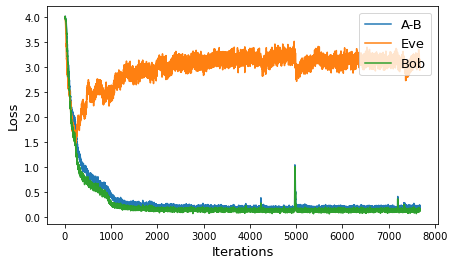

In [18]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B', alpha=0.99)
plt.plot(evelosses[:steps], label='Eve', alpha=0.99)
plt.plot(boblosses[:steps], label='Bob', alpha=0.99)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13, loc='upper right')

#plt.savefig("images/" + model_name + "-all.png", transparent=True) #dpi=100
plt.show()

In [21]:
alice.save('alice_crypto2.h5', overwrite=True)
bob.save('bob_crypto2.h5', overwrite=True)
eve.save('eve_crypto2.h5', overwrite=True)

In [22]:
alice = load_model('alice_crypto2.h5')
bob = load_model('bob_crypto2.h5')
eve = load_model('eve_crypto2.h5')

### Evaluate

In [23]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
#m_enc = np.round(m_enc, 3)
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  86.76 %
Eve % correct:  2.5 %
